In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pathlib
from scipy.stats import ttest_rel

In [12]:
results = []
for results_file in Path(os.getcwd()+os.path.sep+'models_results').rglob('*.csv'):
    if 'training' in str(results_file):continue
    if '.ipynb' in str(results_file):continue
    results_df = pd.read_csv(results_file)
    if not 'base_name' in results_df.columns:
        results_df['base_name']=results_df['file_number']
    results_df = results_df[['base_name' ,'noise','snr','accuracy']]
    file_name = str(results_file).rsplit(os.path.sep)[-1].split('.')[0]
    results_df['model_name'] = file_name
    results_df['batch'] = results_df['model_name'].str.contains('batch')
    results_df['no_delta'] = results_df['model_name'].str.contains('no_delta')
    results.append(results_df)
    
models_performances = pd.concat(results)
print(len(models_performances))
models_performances.head()

97774


,base_name,noise,snr,accuracy,model_name,batch,no_delta
0,ch1_3752-4944-0008.gzip,pink,12,100.000000,batch_rnn_no_delta,True,True
1,ch1_3752-4944-0008.gzip,white,12,100.000000,batch_rnn_no_delta,True,True
2,ch1_84-121123-0000.gzip,car80,12,99.230769,batch_rnn_no_delta,True,True
3,ch1_84-121123-0000.gzip,car80,6,99.230769,batch_rnn_no_delta,True,True
4,ch1_84-121123-0000.gzip,white,12,98.461538,batch_rnn_no_delta,True,True


In [13]:
models_performances.loc[models_performances['model_name']=='deep_neural_net','model_name'] = 'batch_deep_neural_net'

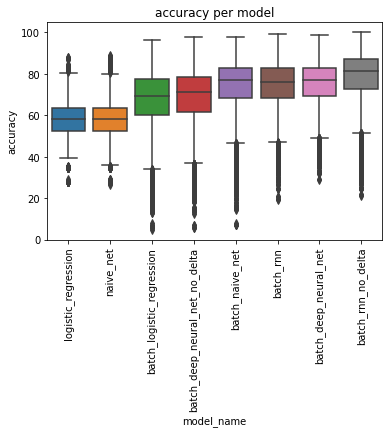

In [14]:
#so how is the best model?
order = models_performances.groupby(by=["model_name"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="model_name" ,y="accuracy",data=models_performances
            , order=order)
p.set_title('accuracy per model')
for label in p.get_xticklabels():
    label.set_rotation(90)
p.figure.savefig("plots/accuracy_per_model.png",dpi=300, bbox_inches = "tight")

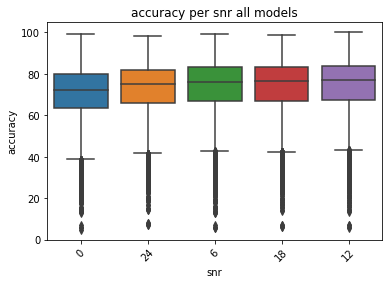

In [15]:
# sainety cheak - are we doing better the higher the snr is?
order = models_performances.groupby(by=["snr"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="snr", y="accuracy",
            data=models_performances
            , order=order)
p.set_title('accuracy per snr all models')
for label in p.get_xticklabels():
    label.set_rotation(45)
p.figure.savefig("plots/accuracy_per_snr.png",dpi=300, bbox_inches = "tight")

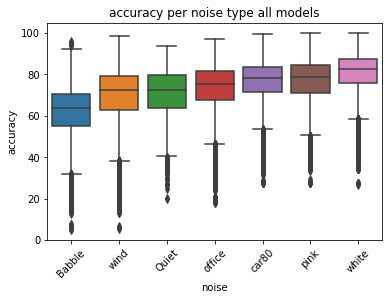

In [16]:
# which noise type is the hardest to get?
order = models_performances.groupby(by=["noise"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="noise", y="accuracy",
            data=models_performances
                ,order=order)
p.set_title('accuracy per noise type all models')
for label in p.get_xticklabels():
    label.set_rotation(45)
p.figure.savefig("plots/accuracy_per_noise.png",dpi=300, bbox_inches = "tight")

In [20]:
training_time = pd.read_csv('training_time.csv')
training_time['seconds'] = training_time['time']
training_time

,model,time,seconds
0,batch_rnn_no_delta,3470,3470
1,batch_rnn,3236,3236
2,batch_naive_net,202,202
3,batch_deep_neural_net_no_delta,199,199
4,batch_deep_neural_net,178,178
5,batch_logistic_regression,175,175
6,logistic_regression,48,48
7,naive_net,42,42


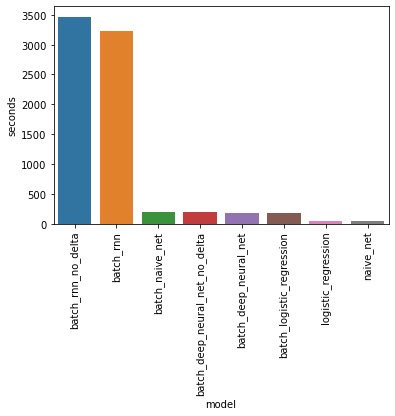

In [21]:
p = sns.barplot(x='model',y='seconds',data = training_time)
for label in p.get_xticklabels():
    label.set_rotation(90)
p.figure.savefig("plots/training_time.png",dpi=300, bbox_inches = "tight")

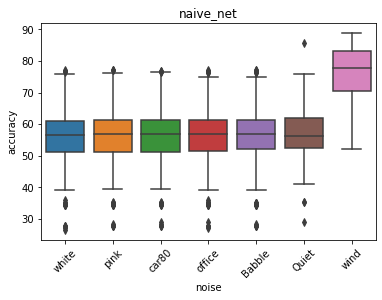

In [22]:
for model_name in models_performances['model_name'].unique():
    
    folder = pathlib.Path(f'plots/{model_name}')
    folder.mkdir(exist_ok=True)

    subseted = models_performances[models_performances['model_name']==model_name]
    
    
    order = subseted.groupby(by=["snr"])["accuracy"].mean().sort_values().index
    plt.cla()
    p = sns.boxplot(x="snr", y="accuracy",
                data=subseted
                , order=order)
    p.set_title(model_name)
    for label in p.get_xticklabels():
        label.set_rotation(45)
    p.figure.savefig(f"plots/{model_name}/accuracy_per_snr.png",dpi=300, bbox_inches = "tight")
    
    
    order = subseted.groupby(by=["noise"])["accuracy"].mean().sort_values().index
    plt.cla()
    p = sns.boxplot(x="noise", y="accuracy",
                data=subseted
                    ,order=order)
    p.set_title(model_name)
    for label in p.get_xticklabels():
        label.set_rotation(45)
    p.figure.savefig(f"plots/{model_name}/accuracy_per_noise.png",dpi=300, bbox_inches = "tight")

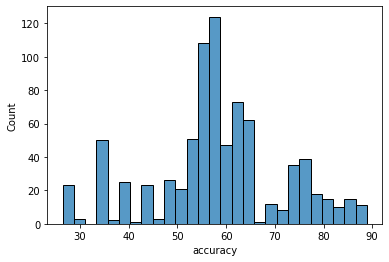

In [25]:
p = sns.histplot(data=subseted, x="accuracy")

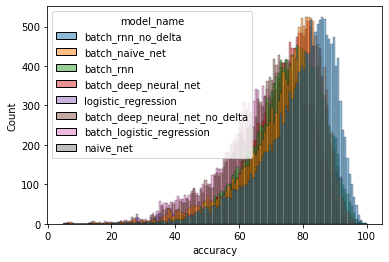

In [27]:
p = sns.histplot(data=models_performances, x="accuracy",hue='model_name')

In [56]:
mean_order = list(models_performances.groupby(by=["model_name"])["accuracy"].mean().sort_values().index)
copuls = list(i for i in zip(mean_order[1:],mean_order[:-1]))
ttest_results = []
for worst_model_name,better_model_name in copuls:
    worst = models_performances[models_performances['model_name']==worst_model_name].copy()
    worst['worst_accuracy']=worst['accuracy']
    better = models_performances[models_performances['model_name']==better_model_name].copy()
    better['better_accuracy']=better['accuracy']
    merged = pd.merge(right=worst,left=better,how='inner',on=['base_name','noise','snr'])
    ttest_p_value = ttest_rel(merged['worst_accuracy'],merged['better_accuracy']).pvalue
    ttest_results.append((better_model_name,worst_model_name,ttest_p_value,len(merged)))
ttest_results=pd.DataFrame.from_records(data = ttest_results, columns = ['worst_model_name','better_model_name','ttest_p_value','number_of_files_compared'])

In [57]:
ttest_results

,worst_model_name,better_model_name,ttest_p_value,number_of_files_compared
0,logistic_regression,naive_net,8.435787e-13,806
1,naive_net,batch_logistic_regression,2.861499e-08,124
2,batch_logistic_regression,batch_deep_neural_net_no_delta,3.224437e-45,16027
3,batch_deep_neural_net_no_delta,batch_naive_net,0.000000e+00,16027
4,batch_naive_net,batch_rnn,1.070586e-10,16027
5,batch_rnn,batch_deep_neural_net,4.125331e-07,16027
6,batch_deep_neural_net,batch_rnn_no_delta,0.000000e+00,16027


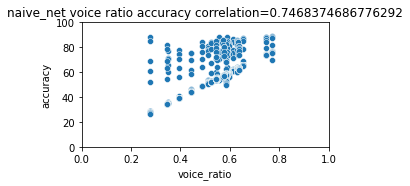

In [74]:
voice_ratio = pd.read_csv('voice_ratio_per_file.csv')
tests_results = [file_path for file_path in Path(os.getcwd()+os.path.sep+'models_results').rglob("*.csv")
                 if not 'train' in str(file_path) and not 'ipynb' in str(file_path)]
for result_path in tests_results:
    model_name = str(result_path).rsplit(os.path.sep)[-1].split('.')[0]
    if model_name=='deep_neural_net':
        model_name='batch_deep_neural_net'
    model_accuracy = pd.read_csv(result_path)
    file_name_column = 'base_name' if 'base_name' in model_accuracy.columns else 'file_number'
    merged = pd.merge(left=voice_ratio ,right=model_accuracy
                      ,left_on='file', right_on=file_name_column
                      ,how='inner')
    correlation = merged['voice_ratio'].corr(merged['accuracy'])
    plt.cla()
    p = sns.scatterplot(x="voice_ratio", y="accuracy", data=merged)
    p.set_xlim(right=1,left=0)
    p.set_ylim(top=100,bottom=0)
    p.set_title(f'{model_name} voice ratio accuracy correlation={correlation}')
    plt.tight_layout()
    p.figure.savefig(f"plots/accuracy_voice_ratio_correlations/{model_name}.png",dpi=300, bbox_inches = "tight")

In [65]:
type(p)

matplotlib.axes._subplots.AxesSubplot